In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/netflix-image/netflix image.jpg
/kaggle/input/netflix-shows/netflix_titles.csv


# **NETFLIX CONTENT BASED RECOMMENDATION SYSTEM**

# Overview
This project builds a content-based recommendation system using TF-IDF vectorization and cosine similarity to suggest movies or TV shows similar to a given title. The dataset, sourced from Netflix, includes metadata such as titles, genres, descriptions, directors, cast, and countries.

# Key Features:

* Exploratory Data Analysis (EDA): Visualizes content distribution by type, country, and genre.Data Preprocessing: Handles missing values and combines relevant text features.TF-IDF Vectorization: Converts textual data into numerical vectors for similarity computation.Cosine Similarity: Measures how closely related two pieces of content are.Recommendation Function: Returns the top 10 most similar movies or shows based on user input.This system helps users discover new content based on what they already enjoy, making it a valuable tool for personalized recommendations. 🚀

# Importing Libraries

In [2]:
# Importing Libraries
# Here we import essential libraries:
# - pandas: for data manipulation
# - sklearn.feature_extraction.text.TfidfVectorizer: to convert text data into numerical format using TF-IDF
# - sklearn.metrics.pairwise.cosine_similarity: to calculate the similarity between two vectors
# - sklearn.impute.SimpleImputer: for handling missing values
# - numpy: for numerical operations
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import SimpleImputer
import numpy as np

# Loading the dataset

In [3]:
Netflix_data = pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv")

# Exploratory Data Analysis

In [4]:
# Exploratory Data Analysis (EDA)
# Let's explore the structure of the data and its key statistics.
print(Netflix_data.info())
print(Netflix_data.describe())
print(Netflix_data.isnull().sum())
Netflix_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
None
       release_year
count   8807.000000
mean    2014.180198
std        8.819312
min     1925.000000
25%     2013.000000
50%     2017.000000
75%     2019.000000
max     2021.000000
show_id            0
type               0
title              0
dire

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


This graph shows that there are more movies than tv shows in the dataset.

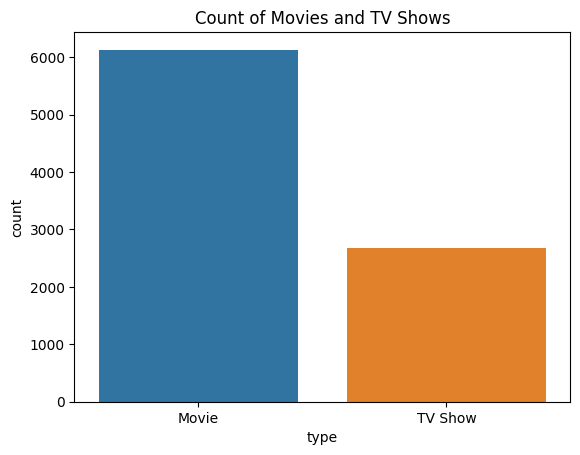

In [5]:
# Visualizing the distribution of content types (Movies vs TV Shows)
sns.countplot(x='type', data = Netflix_data)
plt.title('Count of Movies and TV Shows')
plt.show()

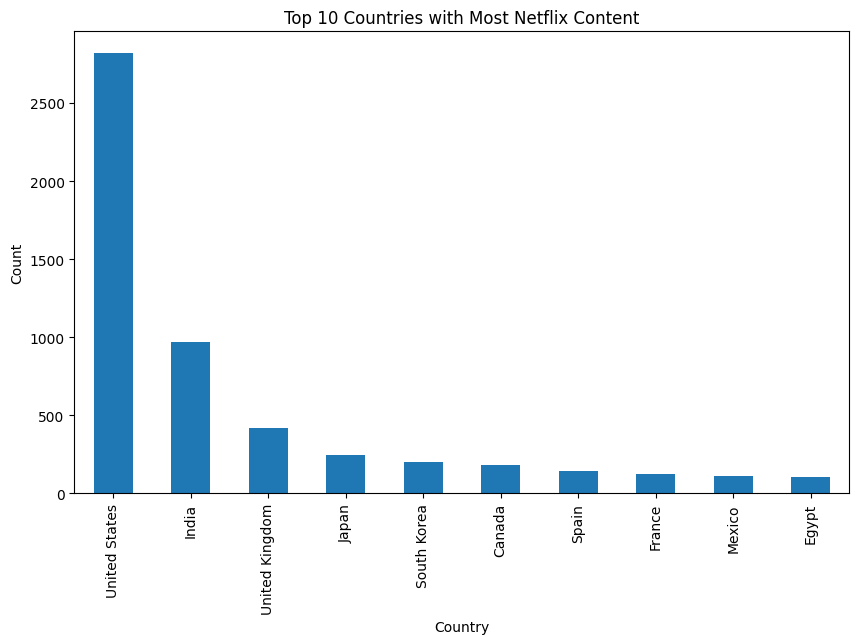

In [6]:

# Top 10 countries with the most content
plt.figure(figsize=(10, 6))
Netflix_data['country'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Countries with Most Netflix Content')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

In [7]:
# Data Cleaning and Preprocessing
# Dropping rows with any missing values and replacing them with blank strings.
data = Netflix_data.fillna('')

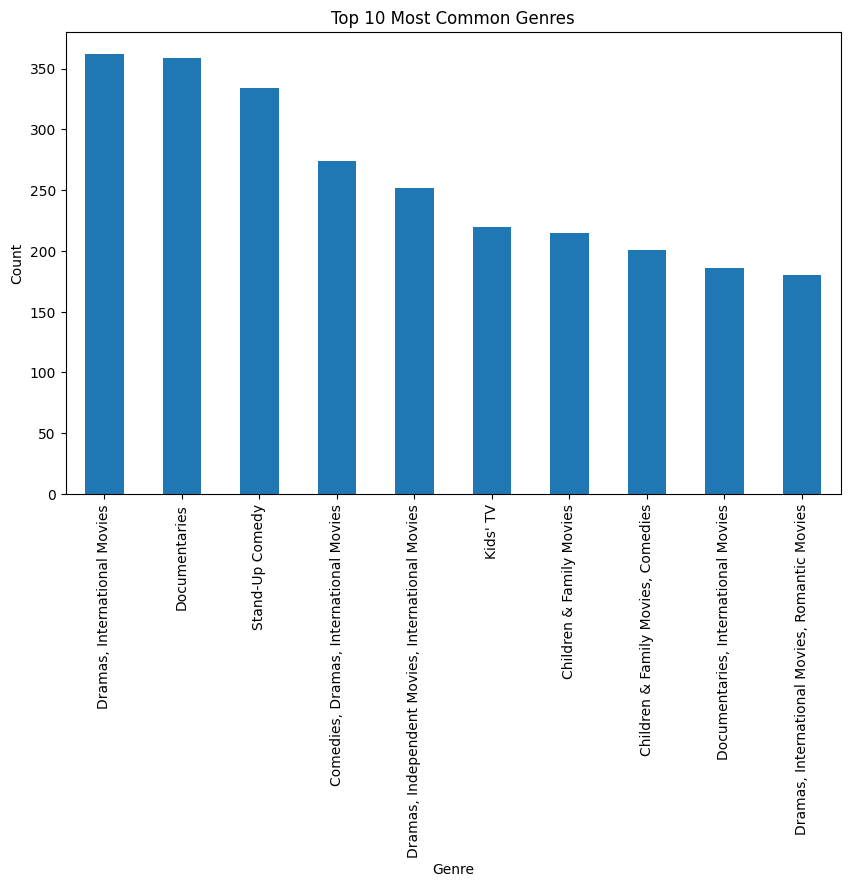

In [8]:
# Most common genres
plt.figure(figsize=(10, 6))
data['listed_in'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Most Common Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

In [9]:
# Here we handle missing values by filling them with the most frequent value in the respective columns.
imputer = SimpleImputer(strategy='most_frequent')
data[['director', 'cast', 'country', 'rating']] = imputer.fit_transform(data[['director', 'cast', 'country', 'rating']])

In [10]:
# Creating a Combined Content Column
# We combine title, genre (listed_in), description, director, cast, and country into a single text feature
# This feature will be used to determine content similarity.
data['content'] = data['title'] + ' ' + data['listed_in'] + ' ' + data['description'] + ' ' + data['director'] + ' ' + data['country'] +' ' + data['cast']

In [11]:
# TF-IDF Vectorization
# We convert the combined text column into numerical vectors using Term Frequency-Inverse Document Frequency (TF-IDF)
# 'stop_words' removes common words.
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['content'])

In [12]:
 #Calculating Cosine Similarity
# Cosine similarity measures the angle between two vectors,closer angles mean higher similarity.
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Creating a Title-Index Mapping
# it map each movie title to its index so we can quickly locate it when making recommendations.
indices = pd.Series(data.index, index=data['title']).drop_duplicates()

# Recommendation Function
# Given a movie title, this function returns the top 10 most similar movies or shows based on content similarity.
# It also includes checks for titles not found in the dataset and formats recommendations neatly.
def get_recommendations(title, cosine_sim=cosine_sim):
    title = title.strip().title()
    if title not in indices:
        return f"The title '{title}' is not in the dataset. Please check spelling or try a different title."
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Top 10 similar movies
    movie_indices = [i[0] for i in sim_scores]
    
    recommendations = data[['title', 'listed_in', 'release_year']].iloc[movie_indices]
    return recommendations


# This block allows users to input a movie or show title and get content-based recommendations.
if __name__ == "__main__":
    user_input = input("Enter a movie or show title: ")
    results = get_recommendations(user_input)
    print(results)

Enter a movie or show title:  Ganglands


                                  title  \
2668                    Earth and Blood   
3976             The Eagle of El-Se'eed   
5488       All Hail King Julien: Exiled   
697   Elite Short Stories: Carla Samuel   
4399                            Warrior   
3789                     Killer Ratings   
5822                            Cocaine   
5480        Tracy Morgan: Staying Alive   
3297                     Paradise Beach   
3425                        Street Flow   

                                              listed_in  release_year  
2668            Dramas, International Movies, Thrillers          2020  
3976  Crime TV Shows, International TV Shows, TV Act...          2018  
5488       Kids' TV, TV Action & Adventure, TV Comedies          2017  
697   International TV Shows, Romantic TV Shows, Spa...          2021  
4399  Crime TV Shows, International TV Shows, TV Dramas          2018  
3789  Crime TV Shows, Docuseries, International TV S...          2019  
5822       British TV 

In [14]:
if __name__ == "__main__":
    user_input = input("Enter a movie or show title: ")
    results = get_recommendations(user_input)
    print(results)

Enter a movie or show title:  The Haunted Hathaways


                          title  \
3         Jailbirds New Orleans   
5699               Back to 1989   
880                     Haunted   
3779  Malibu Rescue: The Series   
2013                The Duchess   
1848                Half & Half   
3806           Prince of Peoria   
7148                 Julius Jr.   
3927                   New Girl   
1057  Dad Stop Embarrassing Me!   

                                              listed_in  release_year  
3                                Docuseries, Reality TV          2021  
5699  International TV Shows, Romantic TV Shows, TV ...          2016  
880                 Reality TV, TV Horror, TV Thrillers          2021  
3779       Kids' TV, TV Action & Adventure, TV Comedies          2019  
2013  British TV Shows, International TV Shows, TV C...          2020  
1848                                        TV Comedies          2005  
3806                              Kids' TV, TV Comedies          2019  
7148                                  